In [1]:
import petri_net_toolkit as pntk
from petri_net_toolkit.nets import *
import numpy as np
import torch
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random
from tqdm import tqdm
import rl_utils

In [2]:
env = TestNet('test_net')

# random init env
init_vec = np.round(10*np.random.rand(env.observation_space[0]))
init_dict = dict()
for i in range(len(init_vec)):
    init_dict['p'+str(i+1)] = {'default': init_vec[i]}
print(init_dict)
env.initialize_net()
env.define_initial(initial_dict=init_dict)
env.reset()
env.draw_net()

{'p1': {'default': 1.0}, 'p2': {'default': 7.0}, 'p3': {'default': 6.0}, 'p4': {'default': 9.0}, 'p5': {'default': 9.0}, 'p6': {'default': 9.0}, 'p7': {'default': 8.0}, 'p8': {'default': 9.0}}


/Users/jason/Documents/SJTU_pro/Projects/DTG/PetriNets/petri_net_toolkit/petri_nets.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pt_matrix.loc[element.name] = np.zeros(len(self.pt_matrix.columns))


In [3]:
env.observation_space

(8, 1)

In [4]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return  F.sigmoid(self.fc2(x))

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps      # PPO-Clip epsilon
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        bernolli = torch.distributions.Bernoulli(probs)
        action_vector = bernolli.sample().reshape(-1).numpy()
        return action_vector

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1-dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        bernoulli = torch.distributions.Bernoulli(self.actor(states))
        old_log_probs = bernoulli.log_prob(actions).sum().detach()

        for _ in range(self.epochs):
            bernoulli_ = torch.distributions.Bernoulli(self.actor(states))
            log_probs = bernoulli_.log_prob(actions).sum()
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps)
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0) 
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            # for name, param in self.actor.named_parameters():
            #     if param.grad is not None:
            #         print(f'Parameter: {name}, Gradient norm: {torch.norm(param.grad)}')


In [6]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.99
lmbda = 0.95
epochs = 10
eps = 0.2


In [7]:
state_dim = env.observation_space[0] * env.observation_space[1]
action_dim = env.action_space
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)

In [8]:
print(state_dim)

8


In [9]:
return_list = []
output_traj = []
dict_list = []
output_time = []
for i in range(60):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = env.reset()
            done = False
            max_T = 200
            T = 0
            traj_8 = []
            trig = np.zeros(env.action_dim)
            ## sample one sequence
            while (not done) and (T < max_T):
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state  
                episode_return += reward
                traj_8.append(env.places['p8'].token['default'])
                T += 1
            output_traj.append(traj_8)
            output_time.append(env.act_time)
            return_list.append(episode_return)
            dict_list.append(transition_dict)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                    'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/7x/vkxy_bn547d757f8znyxd6rh0000gn/T/ipykernel_23467/3809666563.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 0:  52%|█████▏    | 26/50 [00:00<00:00, 42.53it/s, episode=20, return=3936.620]


KeyboardInterrupt: 

In [ ]:
k = 1800
for i in range(len(dict_list[k]['states'])):
    print(dict_list[k]['states'][i])

[2. 6. 6. 2. 7. 5. 1. 8.]
[ 0.  8.  6.  2.  6.  0.  0. 15.]
[ 0.  7.  6.  2.  5.  0.  0. 17.]
[ 0.  5.  6.  2.  5.  0.  0. 19.]
[ 0.  3.  6.  2.  5.  0.  0. 21.]
[ 0.  2.  6.  2.  4.  0.  0. 23.]
[ 0.  1.  6.  2.  3.  0.  0. 25.]
[ 0.  1.  6.  1.  2.  0.  0. 27.]
[ 0.  1.  5.  1.  1.  0.  0. 29.]
[ 0.  1.  4.  1.  0.  0.  0. 31.]
[ 0.  0.  3.  1.  0.  0.  0. 33.]
[ 0.  0.  2.  0.  0.  0.  0. 35.]
[ 0.  0.  1.  0.  0.  0.  0. 36.]


In [ ]:
for a in env.actions:
    print(a.name)

for i in range(len(dict_list[k]['actions'])):
    print(dict_list[k]['actions'][i])

t2
t3
t4
t5
t6
t7
t8
[1. 1. 0. 1. 1. 1. 0.]
[1. 1. 0. 1. 1. 1. 0.]
[1. 1. 0. 1. 1. 0. 0.]
[1. 1. 0. 1. 1. 0. 0.]
[1. 1. 0. 1. 1. 1. 0.]
[1. 1. 0. 1. 1. 1. 0.]
[1. 1. 0. 1. 1. 1. 0.]
[0. 1. 0. 1. 1. 1. 0.]
[0. 1. 0. 1. 1. 1. 0.]
[0. 1. 0. 1. 1. 1. 0.]
[0. 1. 0. 1. 1. 1. 0.]
[0. 1. 0. 1. 1. 1. 0.]
[0. 1. 0. 1. 1. 1. 0.]


In [ ]:
for i in range(len(dict_list[k]['rewards'])):
    print(dict_list[k]['rewards'][i])

1289.9999971556076
299.99999919615004
328.9999991755385
328.9999991755385
299.99999919615004
299.99999919615004
328.79999919615005
318.99999919615004
318.99999919615004
347.7999991755385
376.5999991755385
180.3999995877693
180.3999995877693


In [ ]:
print(output_traj)

[[15.0, 17.0, 19.0, 20.0, 22.0, 24.0, 26.0, 28.0, 29.0, 29.0, 30.0, 31.0, 32.0, 32.0, 33.0, 34.0, 34.0, 34.0, 35.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 37.0], [14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 27.0, 29.0, 31.0, 32.0, 33.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 36.0, 36.0, 37.0], [13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 30.0, 30.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 33.0, 34.0, 35.0, 35.0, 35.0, 36.0, 37.0], [15.0, 15.0, 15.0, 17.0, 18.0, 20.0, 22.0, 24.0, 26.0, 27.0, 27.0, 28.0, 29.0, 31.0, 32.0, 33.0, 34.0, 35.0, 35.0, 36.0, 36.0, 36.0, 37.0], [15.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 27.0, 29.0, 30.0, 31.0, 32.0, 33.0, 33.0, 34.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 37.0], [15.0, 17.0, 19.0, 21.0, 22.0, 23.0, 24.0, 26.0, 27.0, 27.0, 28.0, 29.0, 31.0, 31.0, 31.0, 32.0, 32.0, 33.0, 33.0, 34.0, 34.0, 35.0, 35.0, 36.0, 37.0], [15.0, 17.0, 19.0, 21.0, 22.0, 24.0, 26.0, 28.0, 29.0, 30.0, 31.0, 32

Text(0, 0.5, 'output num')

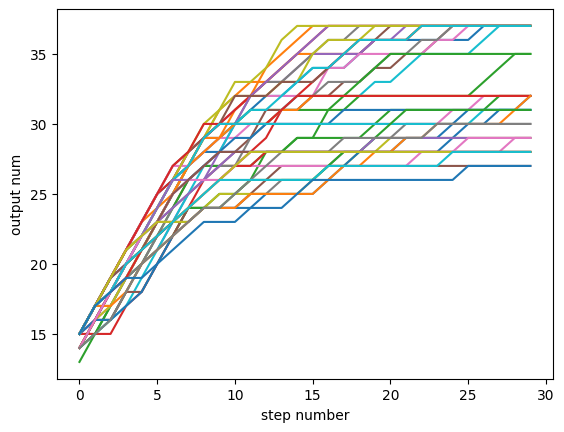

In [ ]:
# ======= plot output traj =======
max_traj = max(len(traj) for traj in output_traj)
step_num = range(max_traj)
for traj in output_traj:
    traj.extend([traj[-1]] * (max_traj - len(traj)))
    
max_step = 30
for i in range(40):
    plt.plot(step_num[:max_step], output_traj[i][:max_step])
plt.plot(step_num[:max_step], output_traj[-1][:max_step])
plt.xlabel('step number')
plt.ylabel('output num')

910


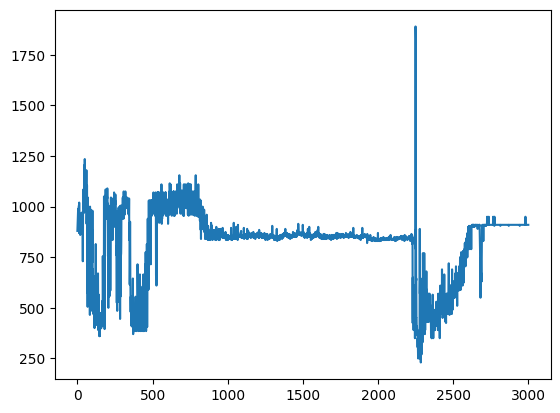

In [ ]:
# ======= plot min finish time =======

print(output_time[-1])
plt.plot(range(len(output_time)), output_time)

[4872.799988210201, 4843.799988230812, 4793.999988251423, 4781.3999882514245, 4743.599988272034, 4742.399988272035, 4836.399988230812, 4837.799988230813, 4836.999988230813, 4837.199988230813, 4711.999988272033, 4892.5999882102005, 4690.599988292646, 4882.399988210201, 4892.599988210201, 4798.199988251423, 4781.199988251424, 4829.399988230813, 4893.399988210201, 4899.199988210201, 4847.199988230812, 4719.799988230789, 4832.599988230811, 4869.7999882102, 4721.999988251417, 4356.9999890552635, 4745.5999882514125, 4729.799988230801, 4730.799988251423, 4767.999988230806, 4762.39998825142, 4754.99998825142, 4770.599988230809, 4694.599988251421, 4436.799988663643, 4326.799989055262, 4085.1999898178915, 4282.5999890552675, 4584.99998827203, 4559.199988292646, 4488.599988313257, 4636.199988292645, 4641.199988292647, 4721.199988272035, 4629.799988292645, 4734.599988251421, 4467.599988375094, 4598.999988313256, 4653.99998831326, 4402.9999883957025, 4488.3999883544775, 4650.199988292641, 4670.7999

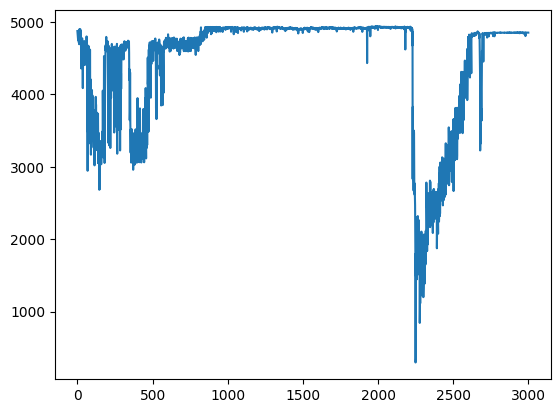

In [ ]:
print(return_list)
plt.plot(range(len(return_list)), return_list)

In [ ]:
test_input = torch.rand(state_dim)
test_output = agent.actor(test_input)
print(agent.actor.state_dict())

OrderedDict([('fc1.weight', tensor([[-0.0275, -0.0010, -0.1871,  ...,  0.1678,  0.2481, -0.2815],
        [ 0.1990, -0.1719, -0.1640,  ...,  0.0649, -0.3334, -0.1218],
        [ 0.4016,  0.1928, -0.1259,  ...,  0.1671,  0.2784,  0.1808],
        ...,
        [-0.3538, -0.0120, -0.0466,  ..., -0.4060, -0.1033,  0.2552],
        [-0.2581,  0.3174,  0.1373,  ..., -0.2011, -0.0193,  0.0724],
        [-0.0677,  0.0838, -0.0433,  ...,  0.1004,  0.1752, -0.0010]])), ('fc1.bias', tensor([ 0.0645,  0.0043,  0.2615, -0.0736,  0.2547,  0.0884,  0.0061,  0.0018,
        -0.1631, -0.0750, -0.3741, -0.1819,  0.3547, -0.2931,  0.0105,  0.3653,
        -0.2265,  0.3656, -0.1924,  0.2387, -0.0582, -0.2444,  0.0294, -0.0849,
        -0.0724,  0.2326,  0.1386,  0.3180, -0.2754,  0.1361,  0.0398, -0.2551,
         0.0112,  0.2317, -0.2387,  0.0025, -0.1222,  0.2738,  0.3175, -0.0429,
         0.1447, -0.0825,  0.2789,  0.2515,  0.2783, -0.0139,  0.3025,  0.0179,
         0.0643,  0.0147, -0.0035,  0.1718,

In [ ]:
probs = torch.tensor([0.8, 0.9, 0.6, 0.1])

# 创建Bernoulli分布对象
bernoulli = torch.distributions.Bernoulli(probs)

# 定义采样序列
samples = torch.tensor([1.0, 1.0, 1.0, 0.0])

# 计算采样序列的概率
log_probs = bernoulli.log_prob(samples)
log_probs_ = log_probs.sum()
prob = torch.exp(log_probs).prod().item()
print(log_probs)
print(log_probs_)
print(prob)
print(torch.exp(log_probs_))

tensor([-0.2231, -0.1054, -0.5108, -0.1054])
tensor(-0.9447)
0.3888000249862671
tensor(0.3888)
